## Feed forward NN

Epoch 1000/1000, Loss: 0.0000: 100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


Test Loss: 7.473076654712785e-06


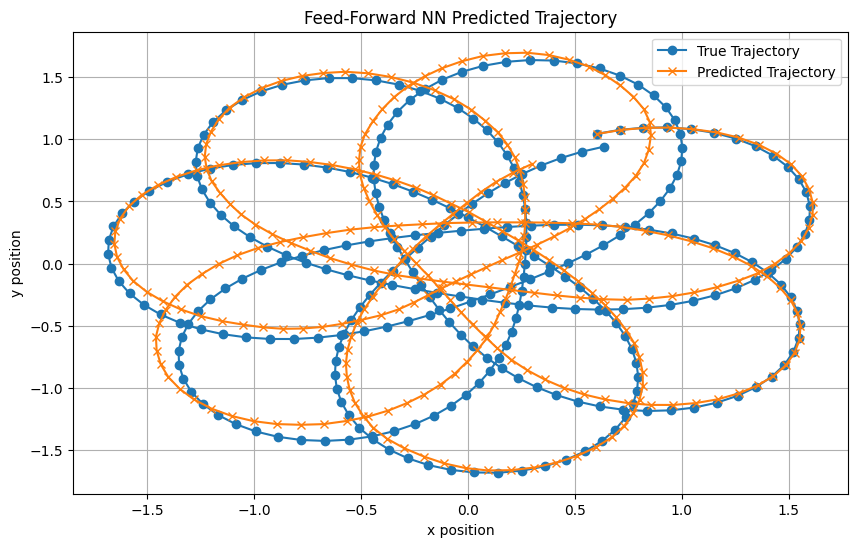

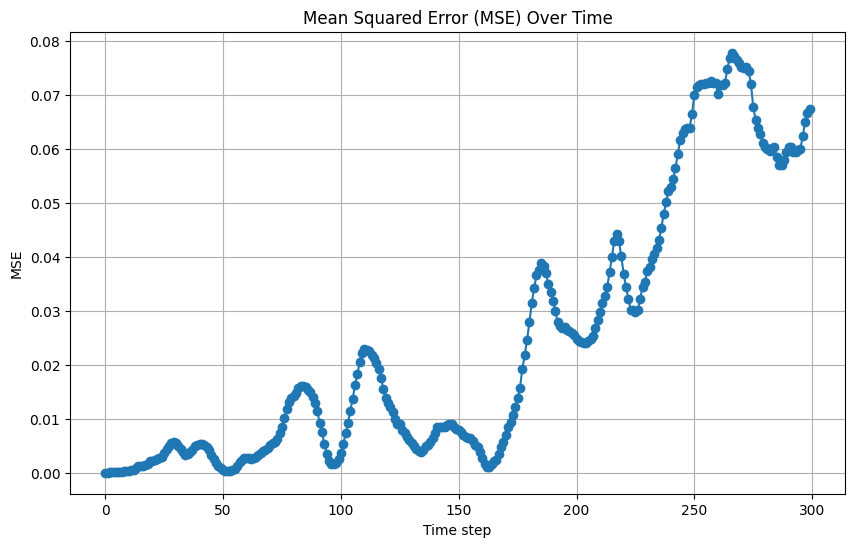

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model

batch_size = 64
num_epochs = 1000


def load_data(file_path):
    data = np.loadtxt(file_path)
    velocities = data[:, :2]
    positions = data[:, 2:]
    return velocities, positions

train_velocities, train_positions = load_data('data_lorentz/train.txt')
test_velocities, test_positions = load_data('data_lorentz/test.txt')

# Create input-output pairs for training
def create_pairs(velocities, positions):
    input_states = np.hstack((velocities[:-1], positions[:-1]))
    output_states = np.hstack((velocities[1:], positions[1:]))
    return input_states, output_states

train_input_states, train_output_states = create_pairs(train_velocities, train_positions)
test_input_states, test_output_states = create_pairs(test_velocities, test_positions)

# Convert data to PyTorch tensors
train_input_states = torch.tensor(train_input_states, dtype=torch.float32)
train_output_states = torch.tensor(train_output_states, dtype=torch.float32)
test_input_states = torch.tensor(test_input_states, dtype=torch.float32)
test_output_states = torch.tensor(test_output_states, dtype=torch.float32)

# Create dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(train_input_states, train_output_states)
test_dataset = torch.utils.data.TensorDataset(test_input_states, test_output_states)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs)
evaluate_model(model, test_loader, criterion)

# Visualization functions
def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

def plot_predicted_trajectories(model, initial_state, true_positions, title, steps=300):
    model.eval()
    predicted_positions = []
    state = initial_state.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        for _ in range(steps):
            predicted_state = model(state)
            predicted_positions.append(predicted_state[:, 2:].numpy())
            state = predicted_state  # Use the output as the next input

    predicted_positions = np.concatenate(predicted_positions, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', marker='o')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_positions

# Prepare initial state for iterative prediction
initial_state = test_input_states[0]

# Extract true positions for comparison
true_positions = test_output_states.numpy()[:300, 2:]

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'Feed-Forward NN Predicted Trajectory')

# Calculate and plot mean squared error (MSE) as a function of time
mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


## Recurrent NN

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Test Loss: 4.4689571336569545e-05


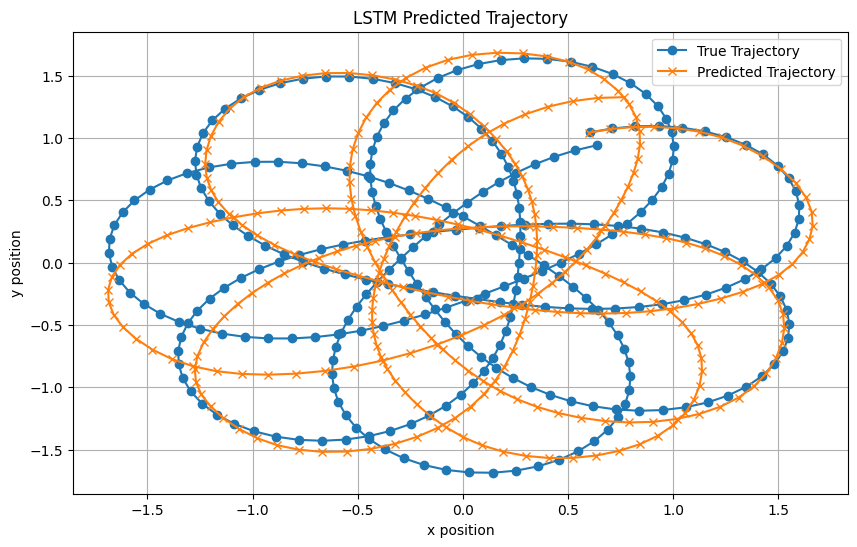

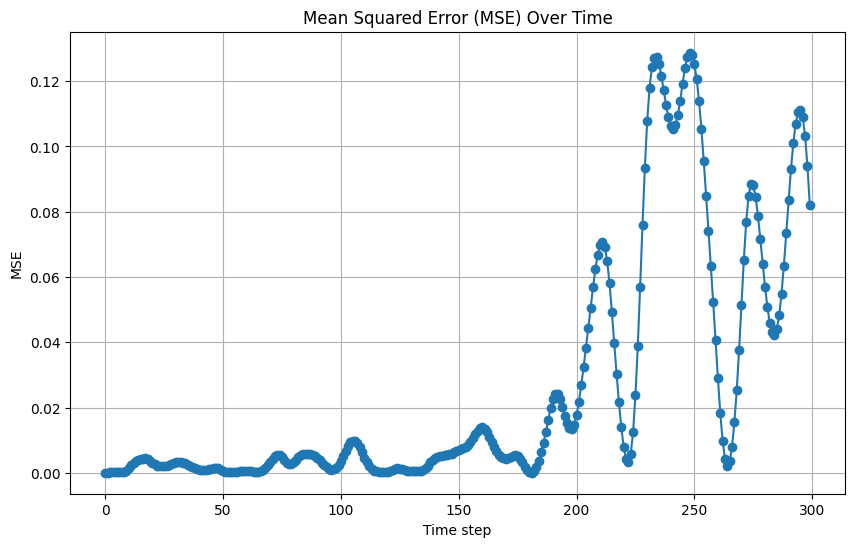

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import RecurrentNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm

batch_size = 64
num_epochs = 100
seq_length = 1  # Single step sequence

# Visualization functions
def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

def plot_predicted_trajectories(model, initial_state, true_positions, title, steps=300):
    model.eval()
    predicted_positions = []
    state = initial_state.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        for _ in range(steps):
            predicted_state = model(state)
            predicted_positions.append(predicted_state[:, 0, 2:].numpy())
            state = predicted_state  # Use the output as the next input

    predicted_positions = np.concatenate(predicted_positions, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', marker='o')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_positions

# Prepare input data for plotting predicted trajectories
def extract_initial_state_and_true_positions(dataloader, steps=300):
    for input_sequences, output_sequences in dataloader:
        initial_state = input_sequences[0]
        true_positions = output_sequences[:steps, 0, 2:]
        return initial_state, true_positions

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the LSTM model, define loss function and optimizer
rnn_model = RecurrentNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the LSTM model
train_model(rnn_model, train_loader, criterion, optimizer, num_epochs=num_epochs)
# Evaluate the LSTM model
evaluate_model(rnn_model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Extract true positions for comparison
true_positions = test_output_states.numpy()[:300, 2:]

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(rnn_model, initial_state, true_positions, 'LSTM Predicted Trajectory', steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


## Physics informed NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm

batch_size = 64
num_epochs = 100
seq_length = 1  # Single step sequence

# Visualization functions
def plot_positions(positions, title):
    x = positions[:, 0]
    y = positions[:, 1]
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.grid(True)
    plt.show()

def plot_predicted_trajectories(model, initial_state, true_positions, title, steps=300):
    model.eval()
    predicted_positions = []
    state = initial_state.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        for _ in range(steps):
            predicted_state = model(state)
            predicted_positions.append(predicted_state[:, 0, 2:].numpy())
            state = predicted_state  # Use the output as the next input

    predicted_positions = np.concatenate(predicted_positions, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], label='True Trajectory', marker='o')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label='Predicted Trajectory', marker='x')
    plt.title(title)
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_positions

# Prepare input data for plotting predicted trajectories
def extract_initial_state_and_true_positions(dataloader, steps=300):
    for input_sequences, output_sequences in dataloader:
        initial_state = input_sequences[0]
        true_positions = output_sequences[:steps, 0, 2:]
        return initial_state, true_positions

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

def PINN_criterion():
    

# Instantiate the LSTM model, define loss function and optimizer
pinn_model = FeedForwardNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = PINN_criterion()
optimizer = optim.Adam(pinn_model.parameters(), lr=0.001)

# Train the PINN model
train_model(pinn_model, train_loader, criterion, optimizer, num_epochs=num_epochs)
# Evaluate the PINN model
evaluate_model(pinn_model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Extract true positions for comparison
true_positions = test_output_states.numpy()[:300, 2:]

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(rnn_model, initial_state, true_positions, 'LSTM Predicted Trajectory', steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.grid(True)
plt.show()
